In [13]:
from pathlib import Path
import os
from PIL import Image

#ORIGINAL_THUMBNAIL_FOLDER_PATH = Path(".\\train_thumbnails")
PROCESSED_THUMBNAIL_FOLDER_PATH = Path("/Users/ryan/Downloads/TF_data/processed_train_thumbnails")

RESIZE_WIDTH = 64
RESIZE_HEIGHT = 64

# Resize all images to the same dimensions

for thumbnail_path in PROCESSED_THUMBNAIL_FOLDER_PATH.iterdir():
    img = Image.open(os.path.join(".", thumbnail_path))

    new_img = img.resize((RESIZE_WIDTH, RESIZE_HEIGHT))

    new_img.save(os.path.join(PROCESSED_THUMBNAIL_FOLDER_PATH, os.path.basename(thumbnail_path)))


In [23]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import csv

import numpy as np
import os.path
from torch.optim.lr_scheduler import ReduceLROnPlateau



label_to_num_dict = {
    "HGSC": 0,
    "LGSC": 1,
    "EC": 2,
    "CC": 3,
    "MC": 4
}

image_id_list = []
label_list = []

with open("train.csv", newline="") as csvfile:
  fileReader = csv.DictReader(csvfile, delimiter=",")
  for row in fileReader:
    if row["is_tma"] == "False":
      image_id_list.append(row["image_id"])
      label_list.append(label_to_num_dict[row["label"]])
#HGSC, LGSC, E, C, M

class_weights = []
for i in range(5):
  class_weights.append(len(label_list)/(label_list.count(i)*5))
class_weights = torch.FloatTensor(class_weights)
class ImageDataset(Dataset):
  def __init__(self, image_id_list, label_list, train_index):
    self.x_data = []
    self.y_data = []

    transform = A.Compose([A.ToFloat(), ToTensorV2()])

    for i in train_index:
      img = np.array(Image.open(os.path.join("processed_train_thumbnails", f"{image_id_list[i]}_thumbnail.png")))
      self.x_data.append(transform(image=img))
      self.y_data.append(label_list[i])


    self.len = len(self.x_data)

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.convlayer1 = nn.Conv2d(3, 32, kernel_size=(5, 5), stride=1, padding=1)
        self.dropout = nn.Dropout(0.25)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        self.convlayer2 = nn.Conv2d(32, 32, kernel_size=(5, 5), stride=1, padding=1)
        self.layer1 = nn.Linear(28800, 512)
        self.fc = nn.Linear(512, 5)

    def forward(self, X):
        out = self.convlayer1(X)
        out = nn.functional.relu(out)
        out = self.dropout(out)
        out = self.convlayer2(out)
        out = nn.functional.relu(out)
        out = self.maxpool(out)
        out = torch.flatten(out, start_dim=1)
        out = self.layer1(out)
        out = self.fc(out)
        return out


def reset_weights(m):
  for i in m.children():
    if hasattr(i, 'reset_parameters'):
      i.reset_parameters()
model = CNNModel()

criterion = nn.CrossEntropyLoss(weight = class_weights)

learning_rate = 0.00005
num_epochs = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


num_folds = 5
kFold = StratifiedKFold(n_splits=num_folds, shuffle=True)
splits = kFold.split(image_id_list, label_list)
num_epochs = 10

results = {}
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, min_lr=1e-6)

for n,(train_index,test_index) in enumerate(splits):
  dataset_train = ImageDataset(image_id_list, label_list, train_index)
  dataset_test = ImageDataset(image_id_list, label_list, test_index)

  train_loader = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
  test_loader = DataLoader(dataset=dataset_test, batch_size=32, shuffle=True)

  #model = CNNModel()
  model.apply(reset_weights)

  learning_rate = 0.00005
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  total_step = len(train_loader)

  for epoch in range(num_epochs):
    current_loss = 0.0

    for i, data in enumerate(train_loader):
      x_imgs, labels = data
      optimizer.zero_grad()

      # Forward pass
      output = model(x_imgs["image"])
      loss = criterion(output, labels)

      # Backward and optimize
      loss.backward()
      optimizer.step()
      scheduler.step(current_loss)

      current_loss += loss.item()
      #_, predicted = torch.max(output.data, 1)
      #print('Predictions for batch {}: {}'.format(i + 1, predicted))
      if (i+1) % 10 == 0:
        print ('Fold # {}, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(n, epoch+1, num_epochs, i+1, total_step, loss.item()))


  correct, all = 0,0
  with torch.no_grad():
    for i, data in enumerate(test_loader):
      x_imgs, labels = data

      output = model(x_imgs["image"])

      _, predicted  = torch.max(output.data, 1)
      print("LABELS: ", labels)
      print('PREDICTED :', predicted)
      all += labels.size(0)
      correct += (predicted == labels).sum().item()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (n, 100.0 * correct / all))
    print('--------------------------------')
    results[n] = 100.0 * (correct / all)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {num_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

Fold # 0, Epoch [1/10], Step [10/13], Loss: 1.9220
Fold # 0, Epoch [2/10], Step [10/13], Loss: 1.6258
Fold # 0, Epoch [3/10], Step [10/13], Loss: 1.5235
Fold # 0, Epoch [4/10], Step [10/13], Loss: 1.4687
Fold # 0, Epoch [5/10], Step [10/13], Loss: 1.5436
Fold # 0, Epoch [6/10], Step [10/13], Loss: 1.4331
Fold # 0, Epoch [7/10], Step [10/13], Loss: 1.5177
Fold # 0, Epoch [8/10], Step [10/13], Loss: 1.3614
Fold # 0, Epoch [9/10], Step [10/13], Loss: 1.2820
Fold # 0, Epoch [10/10], Step [10/13], Loss: 1.3528
LABELS:  tensor([0, 2, 4, 2, 2, 0, 2, 4, 2, 1, 2, 3, 3, 0, 2, 1, 3, 0, 0, 2, 4, 0, 4, 3,
        0, 3, 4, 0, 3, 1, 0, 2])
PREDICTED : tensor([1, 3, 2, 2, 1, 2, 1, 2, 0, 3, 2, 2, 2, 3, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2,
        1, 1, 3, 2, 1, 3, 1, 0])
LABELS:  tensor([0, 3, 1, 0, 3, 0, 2, 2, 0, 3, 2, 2, 0, 1, 0, 3, 3, 0, 4, 0, 0, 3, 0, 0,
        0, 0, 3, 0, 0, 2, 0, 0])
PREDICTED : tensor([1, 1, 1, 2, 1, 0, 1, 3, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 1, 1,
        2, 2, 2, 1, 1, 1, 1,

Fold # 3, Epoch [1/5], Step [10/26], Loss: 1.5953737497329712
Fold # 3, Epoch [1/5], Step [20/26], Loss: 1.5249422788619995
Fold # 3, Epoch [2/5], Step [10/26], Loss: 1.6571162939071655
Fold # 3, Epoch [2/5], Step [20/26], Loss: 1.6039695739746094
Fold # 3, Epoch [3/5], Step [10/26], Loss: 1.6292917728424072
Fold # 3, Epoch [3/5], Step [20/26], Loss: 1.292575478553772
Fold # 3, Epoch [4/5], Step [10/26], Loss: 1.4871686697006226
Fold # 3, Epoch [4/5], Step [20/26], Loss: 1.2937123775482178
Fold # 3, Epoch [5/5], Step [10/26], Loss: 1.243462085723877
Fold # 3, Epoch [5/5], Step [20/26], Loss: 1.5982444286346436


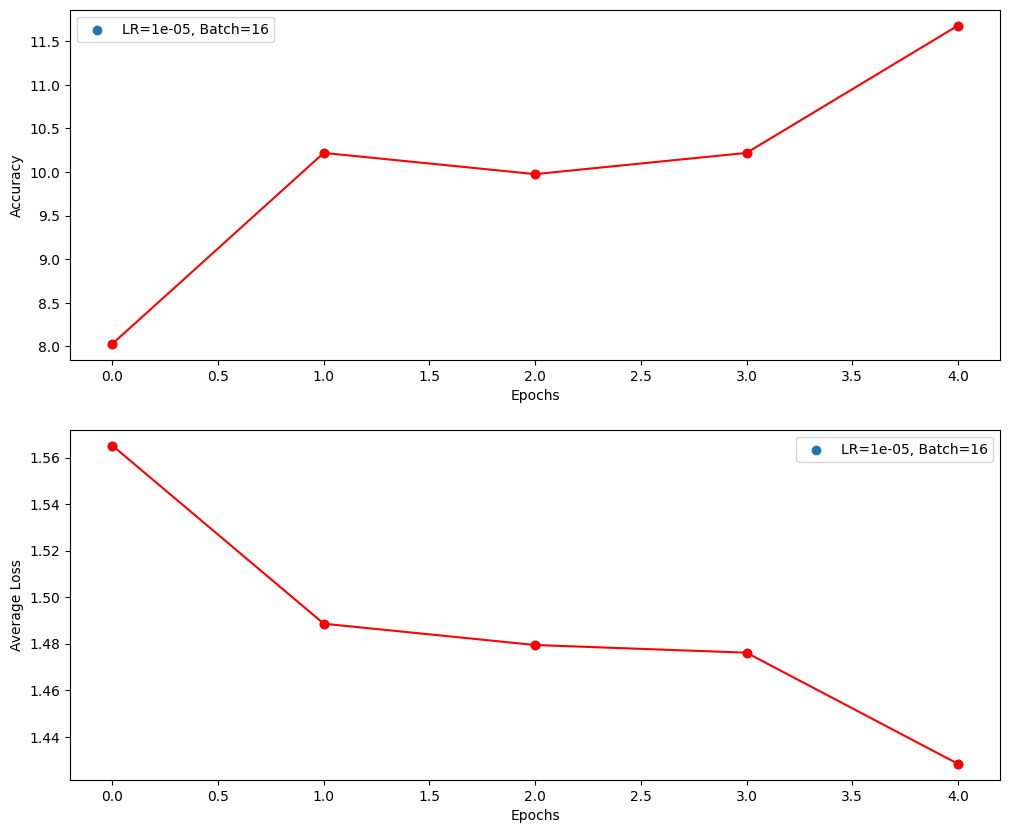

Fold # 3, Epoch [1/5], Step [10/13], Loss: 1.530910611152649
Fold # 3, Epoch [2/5], Step [10/13], Loss: 1.5860767364501953
Fold # 3, Epoch [3/5], Step [10/13], Loss: 1.4020191431045532
Fold # 3, Epoch [4/5], Step [10/13], Loss: 1.4001085758209229
Fold # 3, Epoch [5/5], Step [10/13], Loss: 1.4337859153747559


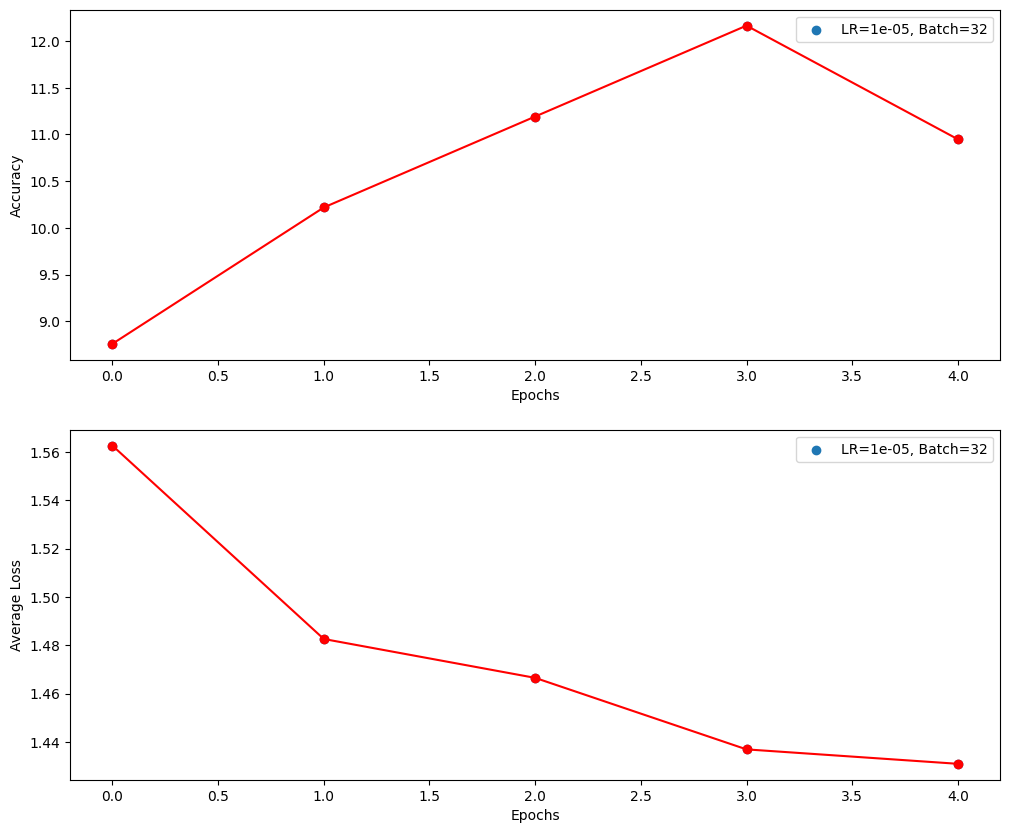

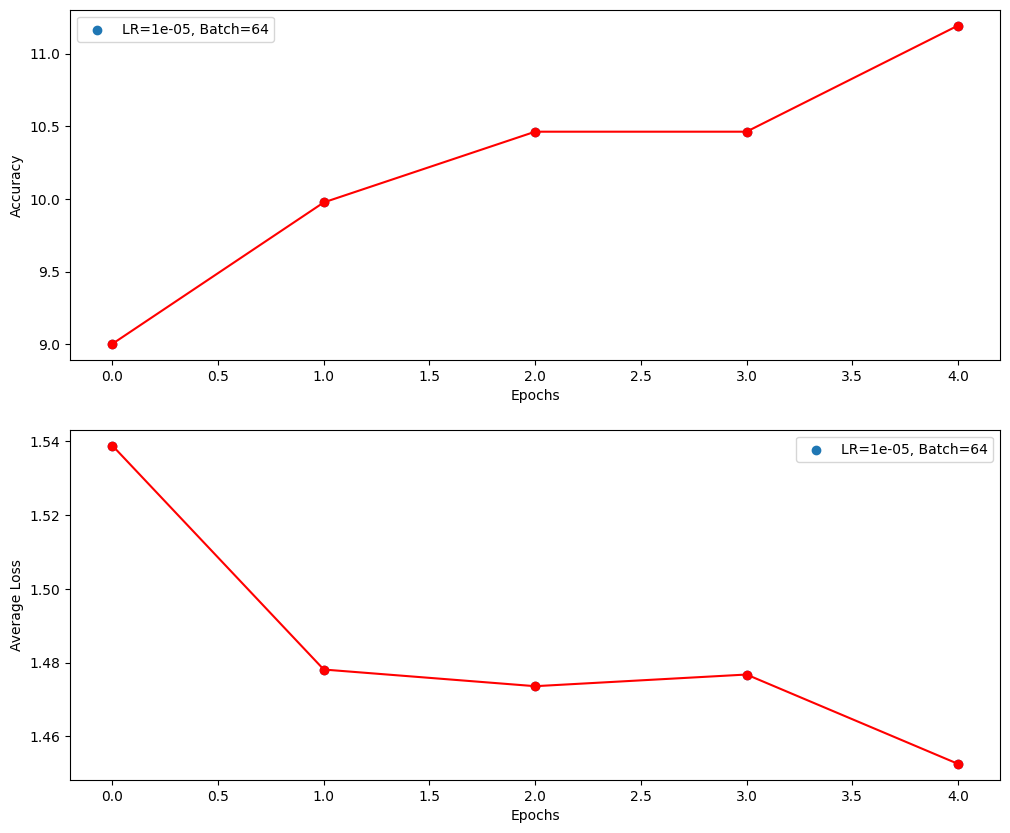

Fold # 3, Epoch [1/5], Step [10/26], Loss: 1.456246256828308
Fold # 3, Epoch [1/5], Step [20/26], Loss: 1.5567139387130737
Fold # 3, Epoch [2/5], Step [10/26], Loss: 1.3936997652053833
Fold # 3, Epoch [2/5], Step [20/26], Loss: 1.2640864849090576
Fold # 3, Epoch [3/5], Step [10/26], Loss: 1.3688311576843262
Fold # 3, Epoch [3/5], Step [20/26], Loss: 1.1005388498306274
Fold # 3, Epoch [4/5], Step [10/26], Loss: 1.089460849761963
Fold # 3, Epoch [4/5], Step [20/26], Loss: 0.9916835427284241
Fold # 3, Epoch [5/5], Step [10/26], Loss: 1.2757776975631714
Fold # 3, Epoch [5/5], Step [20/26], Loss: 1.3152107000350952


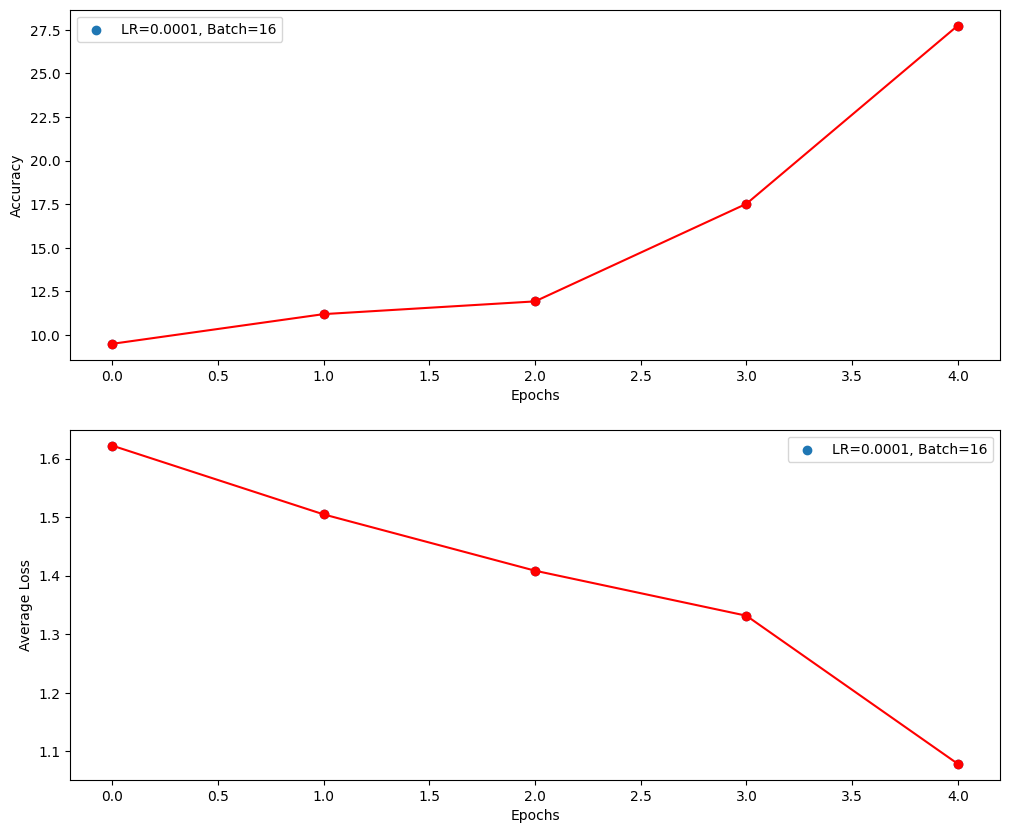

Fold # 3, Epoch [1/5], Step [10/13], Loss: 1.7114298343658447
Fold # 3, Epoch [2/5], Step [10/13], Loss: 1.766023874282837
Fold # 3, Epoch [3/5], Step [10/13], Loss: 1.254120111465454
Fold # 3, Epoch [4/5], Step [10/13], Loss: 1.3249138593673706
Fold # 3, Epoch [5/5], Step [10/13], Loss: 1.238959550857544


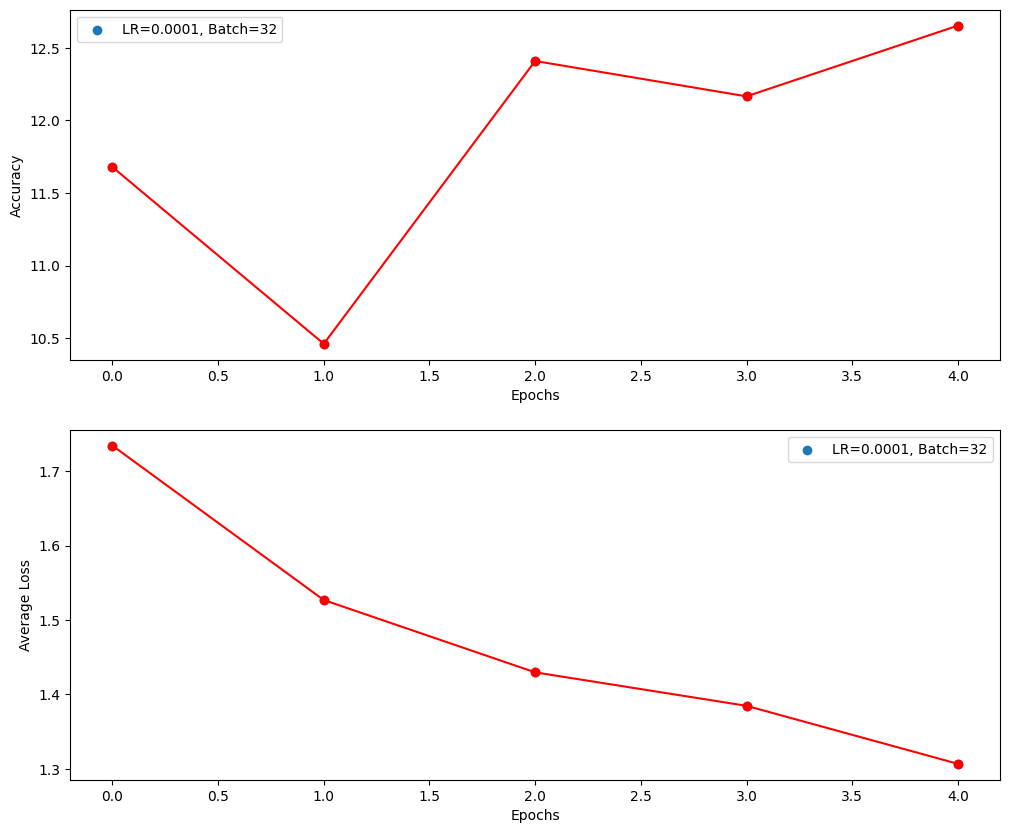

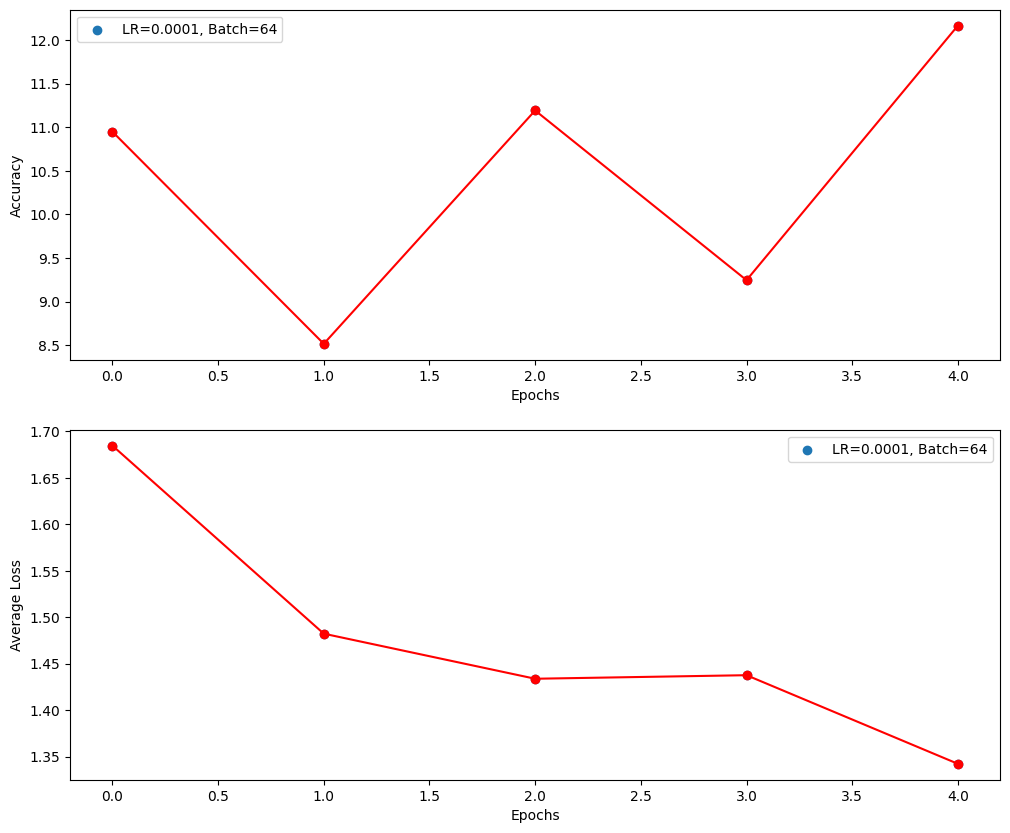

Fold # 3, Epoch [1/10], Step [10/26], Loss: 1.4666699171066284
Fold # 3, Epoch [1/10], Step [20/26], Loss: 2.023914337158203
Fold # 3, Epoch [2/10], Step [10/26], Loss: 1.5501670837402344
Fold # 3, Epoch [2/10], Step [20/26], Loss: 1.5422241687774658
Fold # 3, Epoch [3/10], Step [10/26], Loss: 1.81920325756073
Fold # 3, Epoch [3/10], Step [20/26], Loss: 1.6468263864517212
Fold # 3, Epoch [4/10], Step [10/26], Loss: 1.4129530191421509
Fold # 3, Epoch [4/10], Step [20/26], Loss: 1.36831533908844
Fold # 3, Epoch [5/10], Step [10/26], Loss: 1.358951449394226
Fold # 3, Epoch [5/10], Step [20/26], Loss: 1.8794629573822021
Fold # 3, Epoch [6/10], Step [10/26], Loss: 1.4624063968658447
Fold # 3, Epoch [6/10], Step [20/26], Loss: 1.4998948574066162
Fold # 3, Epoch [7/10], Step [10/26], Loss: 1.491758942604065
Fold # 3, Epoch [7/10], Step [20/26], Loss: 1.2334905862808228
Fold # 3, Epoch [8/10], Step [10/26], Loss: 1.3737014532089233
Fold # 3, Epoch [8/10], Step [20/26], Loss: 1.1502403020858765

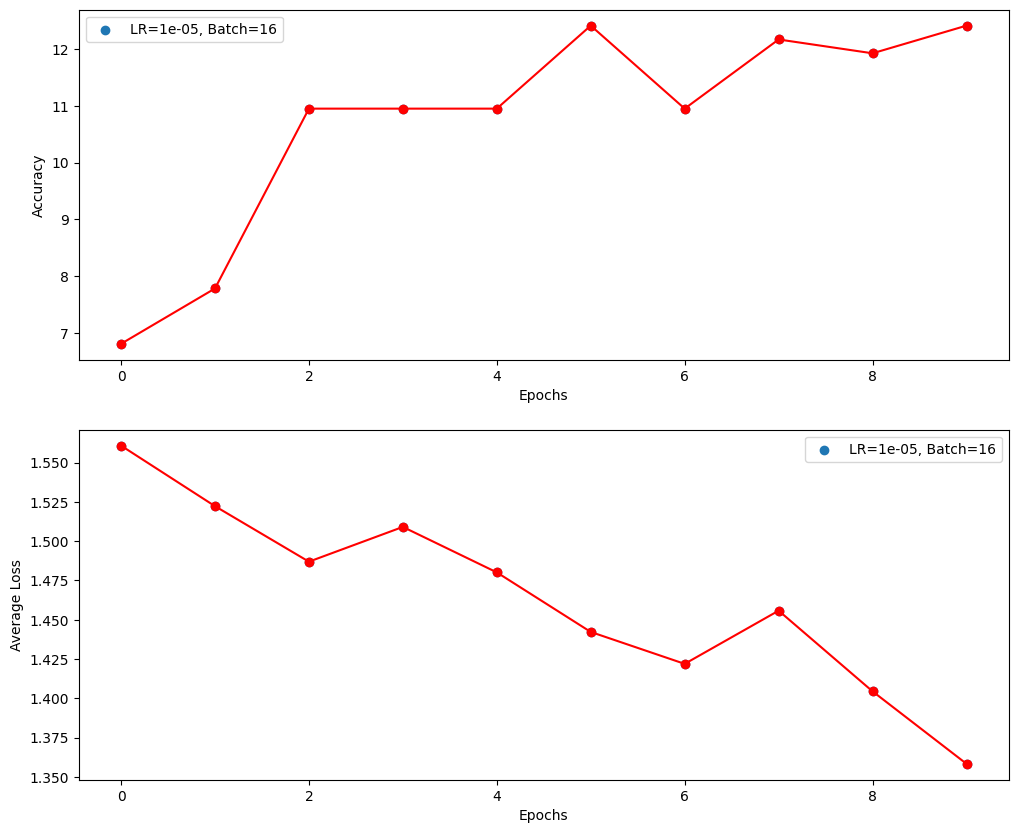

Fold # 3, Epoch [1/10], Step [10/13], Loss: 1.6655073165893555
Fold # 3, Epoch [2/10], Step [10/13], Loss: 1.698254108428955
Fold # 3, Epoch [3/10], Step [10/13], Loss: 1.6410681009292603
Fold # 3, Epoch [4/10], Step [10/13], Loss: 1.5434967279434204
Fold # 3, Epoch [5/10], Step [10/13], Loss: 1.5446703433990479
Fold # 3, Epoch [6/10], Step [10/13], Loss: 1.4908592700958252
Fold # 3, Epoch [7/10], Step [10/13], Loss: 1.382723331451416
Fold # 3, Epoch [8/10], Step [10/13], Loss: 1.2775611877441406
Fold # 3, Epoch [9/10], Step [10/13], Loss: 1.4842053651809692
Fold # 3, Epoch [10/10], Step [10/13], Loss: 1.268056869506836


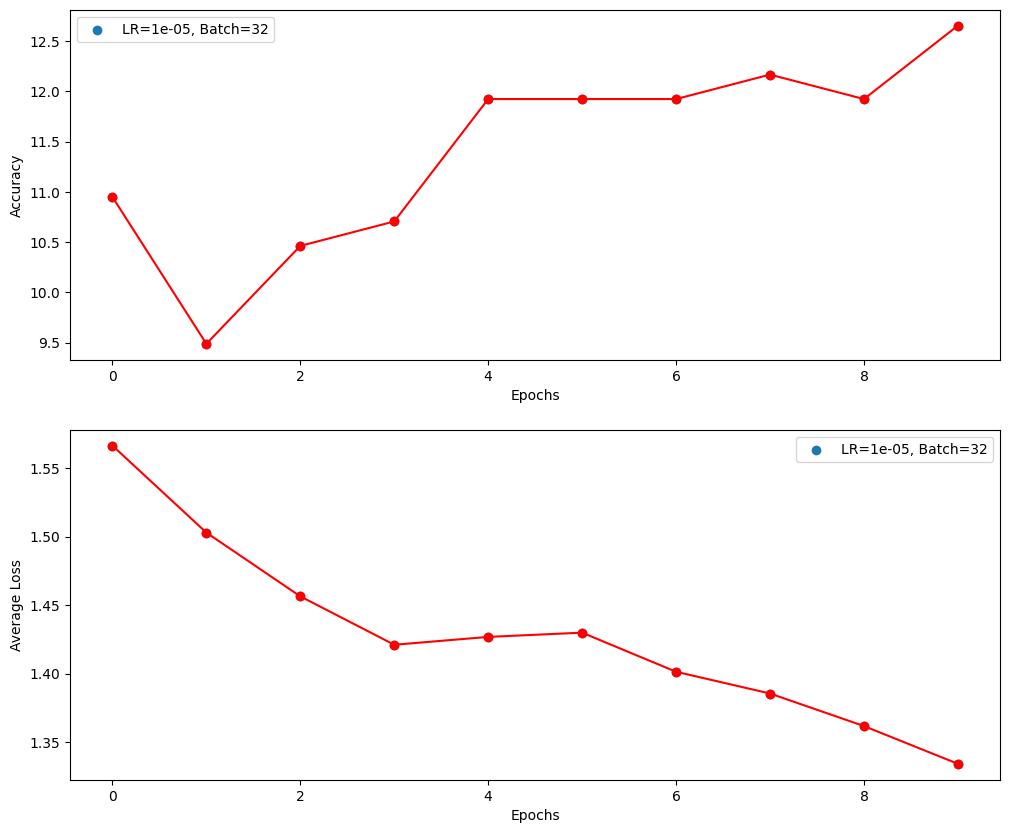

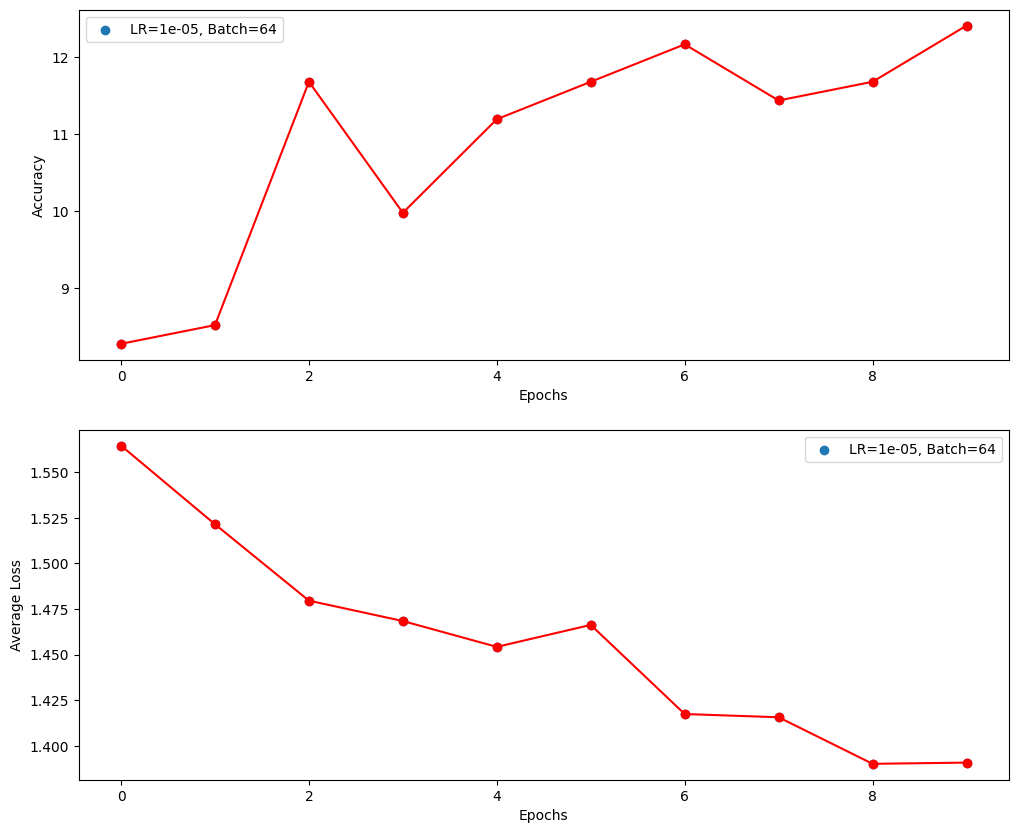

Fold # 3, Epoch [1/10], Step [10/26], Loss: 2.025886297225952
Fold # 3, Epoch [1/10], Step [20/26], Loss: 1.6054644584655762
Fold # 3, Epoch [2/10], Step [10/26], Loss: 1.5945067405700684
Fold # 3, Epoch [2/10], Step [20/26], Loss: 1.2928930521011353
Fold # 3, Epoch [3/10], Step [10/26], Loss: 1.4712311029434204
Fold # 3, Epoch [3/10], Step [20/26], Loss: 1.4826223850250244
Fold # 3, Epoch [4/10], Step [10/26], Loss: 1.91946542263031
Fold # 3, Epoch [4/10], Step [20/26], Loss: 1.1906187534332275
Fold # 3, Epoch [5/10], Step [10/26], Loss: 0.9898308515548706
Fold # 3, Epoch [5/10], Step [20/26], Loss: 1.4675729274749756
Fold # 3, Epoch [6/10], Step [10/26], Loss: 0.8878635168075562
Fold # 3, Epoch [6/10], Step [20/26], Loss: 1.299165964126587
Fold # 3, Epoch [7/10], Step [10/26], Loss: 0.5749576091766357
Fold # 3, Epoch [7/10], Step [20/26], Loss: 0.5094972252845764
Fold # 3, Epoch [8/10], Step [10/26], Loss: 0.5782294869422913
Fold # 3, Epoch [8/10], Step [20/26], Loss: 0.5297141075134

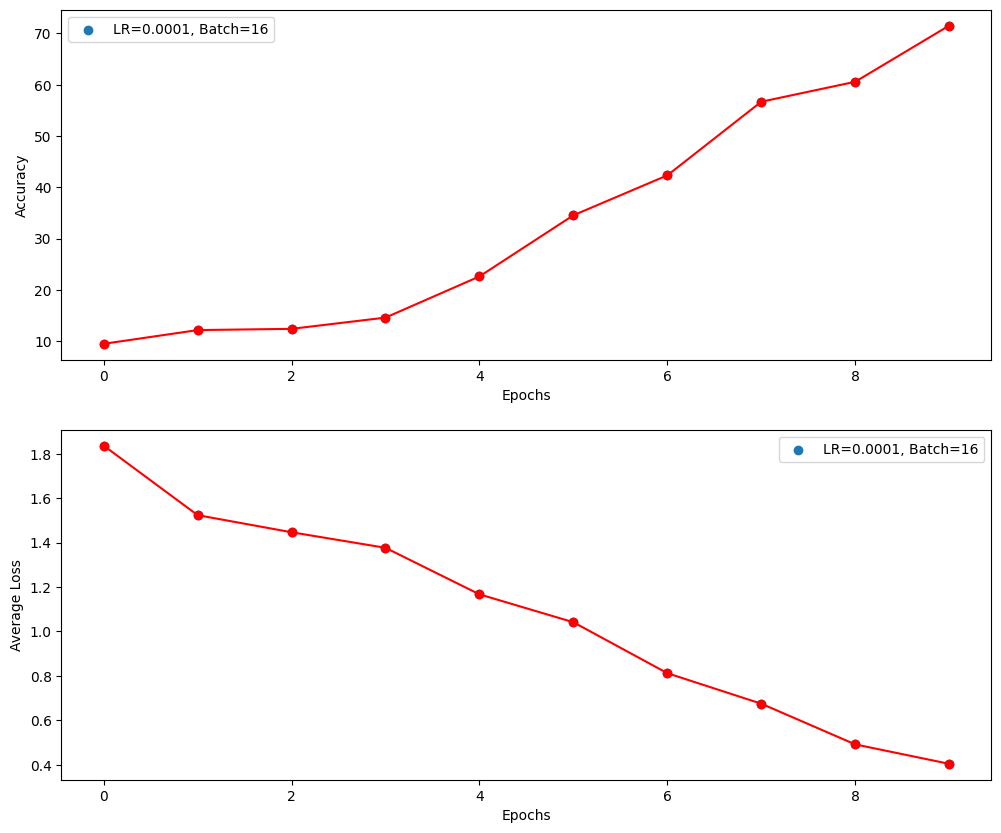

Fold # 3, Epoch [1/10], Step [10/13], Loss: 1.3497612476348877
Fold # 3, Epoch [2/10], Step [10/13], Loss: 1.4525991678237915
Fold # 3, Epoch [3/10], Step [10/13], Loss: 1.3897690773010254
Fold # 3, Epoch [4/10], Step [10/13], Loss: 1.5207829475402832
Fold # 3, Epoch [5/10], Step [10/13], Loss: 1.2330716848373413
Fold # 3, Epoch [6/10], Step [10/13], Loss: 1.0401763916015625
Fold # 3, Epoch [7/10], Step [10/13], Loss: 1.083957552909851
Fold # 3, Epoch [8/10], Step [10/13], Loss: 1.091219425201416
Fold # 3, Epoch [9/10], Step [10/13], Loss: 0.7670255899429321
Fold # 3, Epoch [10/10], Step [10/13], Loss: 0.7504044771194458


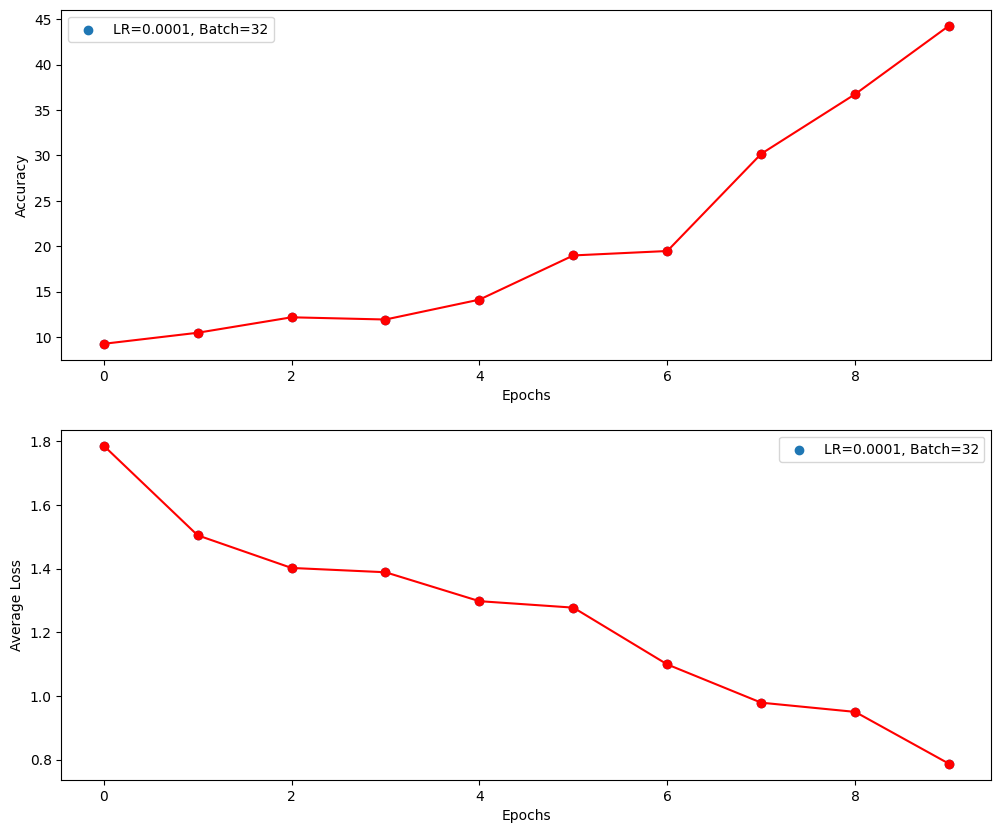

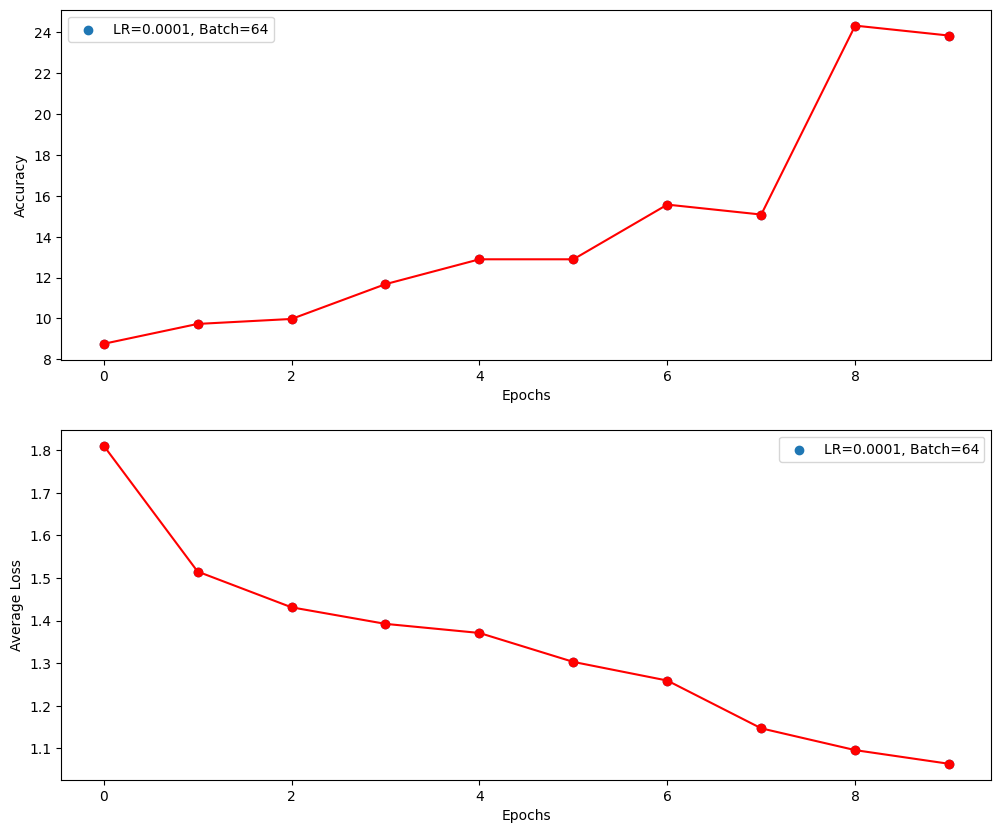

Fold # 3, Epoch [1/15], Step [10/26], Loss: 1.5349788665771484
Fold # 3, Epoch [1/15], Step [20/26], Loss: 1.608832597732544
Fold # 3, Epoch [2/15], Step [10/26], Loss: 1.1923012733459473
Fold # 3, Epoch [2/15], Step [20/26], Loss: 1.6648739576339722
Fold # 3, Epoch [3/15], Step [10/26], Loss: 1.592373251914978
Fold # 3, Epoch [3/15], Step [20/26], Loss: 1.5045876502990723
Fold # 3, Epoch [4/15], Step [10/26], Loss: 1.6661429405212402
Fold # 3, Epoch [4/15], Step [20/26], Loss: 1.3229442834854126
Fold # 3, Epoch [5/15], Step [10/26], Loss: 1.4005095958709717
Fold # 3, Epoch [5/15], Step [20/26], Loss: 1.4315214157104492
Fold # 3, Epoch [6/15], Step [10/26], Loss: 1.539466381072998
Fold # 3, Epoch [6/15], Step [20/26], Loss: 1.498063564300537
Fold # 3, Epoch [7/15], Step [10/26], Loss: 1.5891542434692383
Fold # 3, Epoch [7/15], Step [20/26], Loss: 1.4629369974136353
Fold # 3, Epoch [8/15], Step [10/26], Loss: 1.4158941507339478
Fold # 3, Epoch [8/15], Step [20/26], Loss: 1.1619936227798

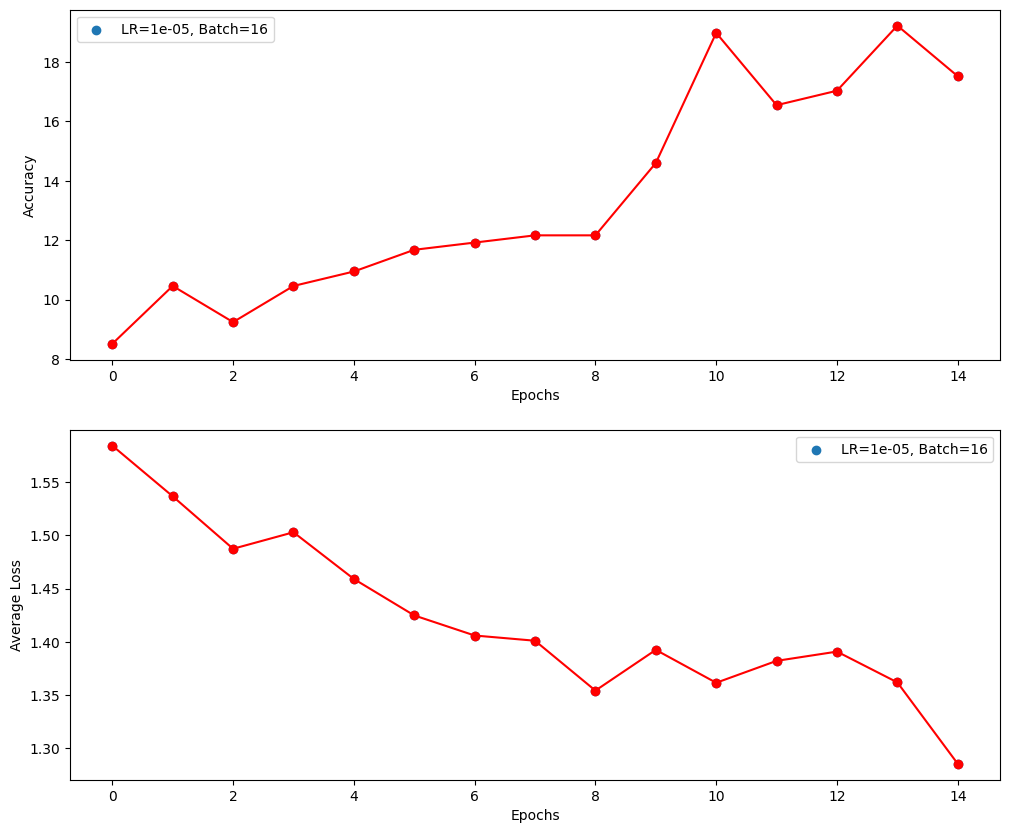

Fold # 3, Epoch [1/15], Step [10/13], Loss: 1.5620338916778564
Fold # 3, Epoch [2/15], Step [10/13], Loss: 2.165109157562256
Fold # 3, Epoch [3/15], Step [10/13], Loss: 1.4289896488189697
Fold # 3, Epoch [4/15], Step [10/13], Loss: 1.5279878377914429
Fold # 3, Epoch [5/15], Step [10/13], Loss: 1.4163705110549927
Fold # 3, Epoch [6/15], Step [10/13], Loss: 1.486301302909851
Fold # 3, Epoch [7/15], Step [10/13], Loss: 1.4415167570114136
Fold # 3, Epoch [8/15], Step [10/13], Loss: 1.3850128650665283
Fold # 3, Epoch [9/15], Step [10/13], Loss: 1.4236059188842773
Fold # 3, Epoch [10/15], Step [10/13], Loss: 1.151032567024231
Fold # 3, Epoch [11/15], Step [10/13], Loss: 1.3026351928710938
Fold # 3, Epoch [12/15], Step [10/13], Loss: 1.3191334009170532
Fold # 3, Epoch [13/15], Step [10/13], Loss: 1.2428674697875977
Fold # 3, Epoch [14/15], Step [10/13], Loss: 1.2091706991195679
Fold # 3, Epoch [15/15], Step [10/13], Loss: 1.1589908599853516


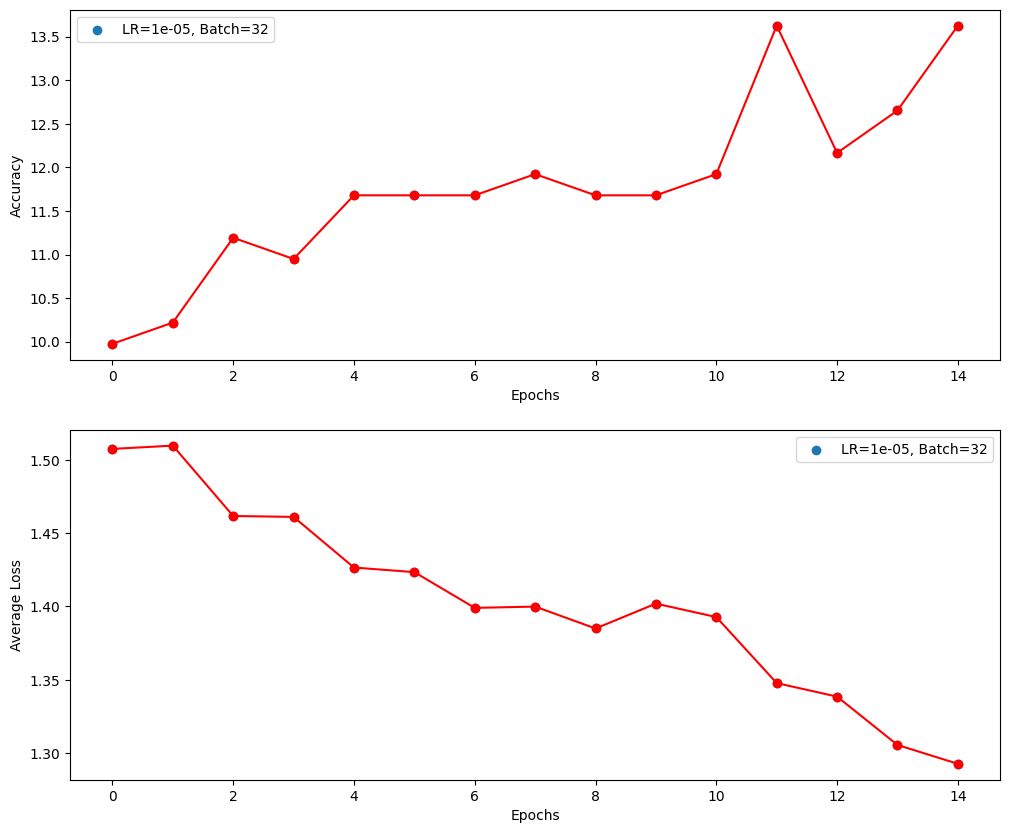

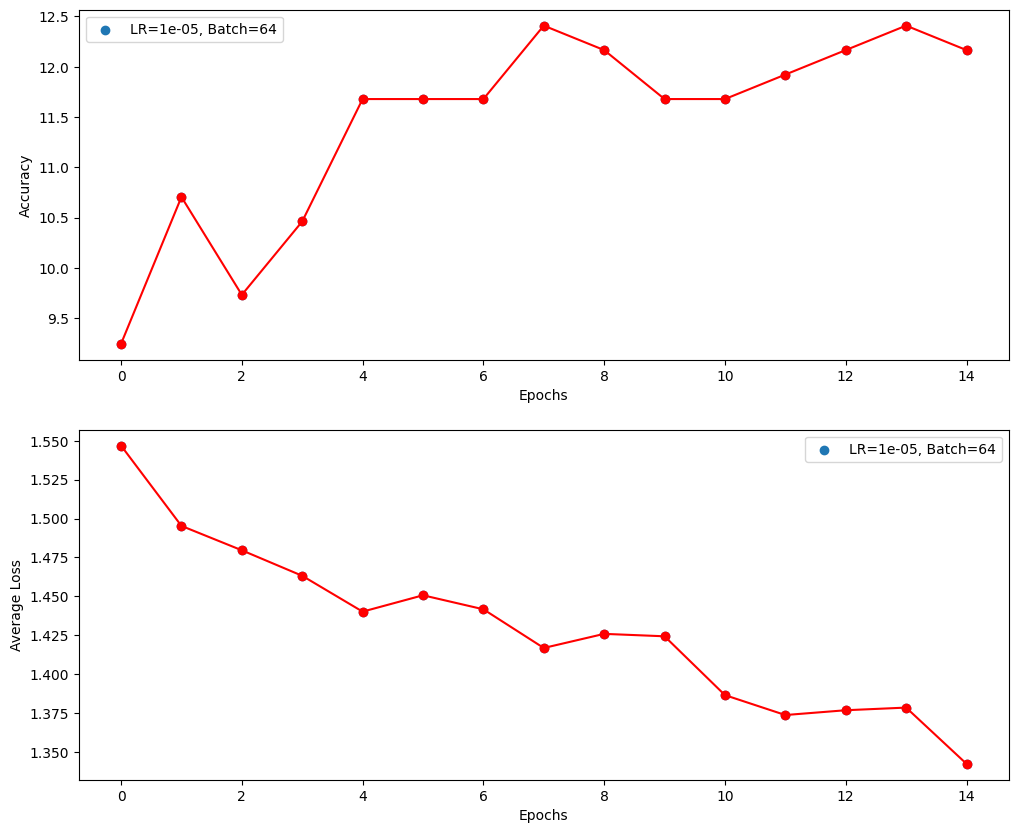

Fold # 3, Epoch [1/15], Step [10/26], Loss: 1.6763849258422852
Fold # 3, Epoch [1/15], Step [20/26], Loss: 1.1880357265472412
Fold # 3, Epoch [2/15], Step [10/26], Loss: 1.663736343383789
Fold # 3, Epoch [2/15], Step [20/26], Loss: 1.4397672414779663
Fold # 3, Epoch [3/15], Step [10/26], Loss: 1.7092499732971191
Fold # 3, Epoch [3/15], Step [20/26], Loss: 1.7107818126678467
Fold # 3, Epoch [4/15], Step [10/26], Loss: 1.0146675109863281
Fold # 3, Epoch [4/15], Step [20/26], Loss: 1.309408187866211
Fold # 3, Epoch [5/15], Step [10/26], Loss: 1.0644850730895996
Fold # 3, Epoch [5/15], Step [20/26], Loss: 1.206492304801941
Fold # 3, Epoch [6/15], Step [10/26], Loss: 0.8830263614654541
Fold # 3, Epoch [6/15], Step [20/26], Loss: 0.8244938254356384
Fold # 3, Epoch [7/15], Step [10/26], Loss: 0.9282326698303223
Fold # 3, Epoch [7/15], Step [20/26], Loss: 0.5756372213363647
Fold # 3, Epoch [8/15], Step [10/26], Loss: 0.7310556769371033
Fold # 3, Epoch [8/15], Step [20/26], Loss: 0.548025667667

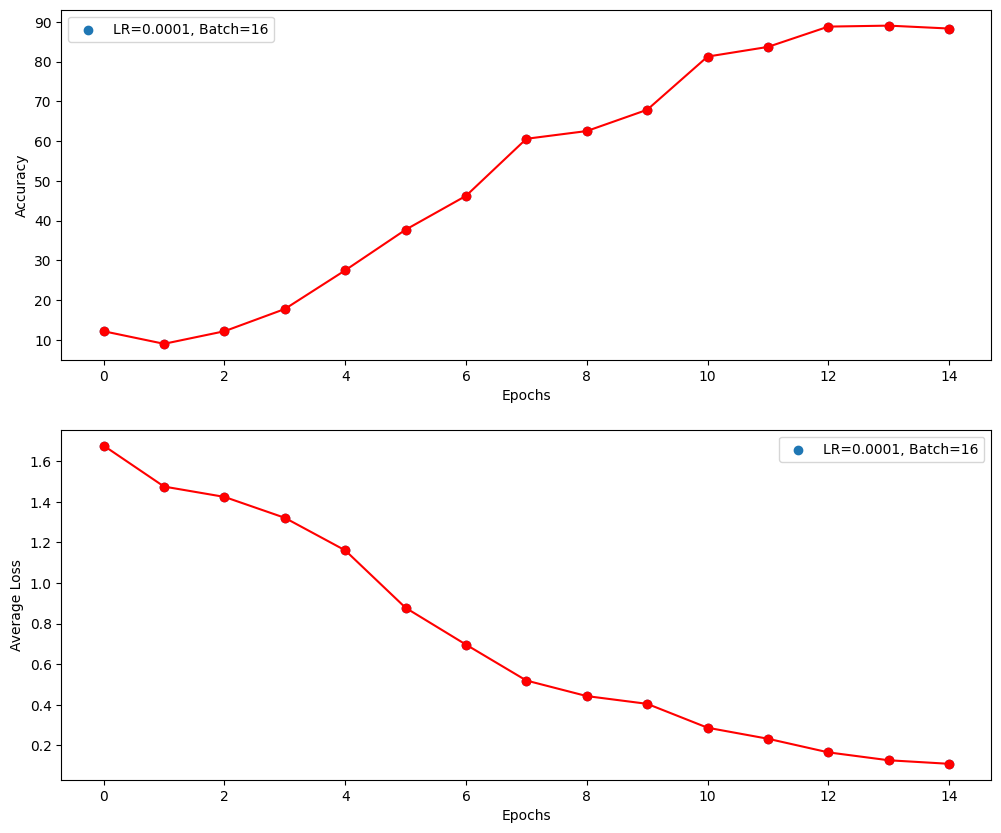

Fold # 3, Epoch [1/15], Step [10/13], Loss: 1.8457878828048706
Fold # 3, Epoch [2/15], Step [10/13], Loss: 1.5166637897491455
Fold # 3, Epoch [3/15], Step [10/13], Loss: 1.6650176048278809
Fold # 3, Epoch [4/15], Step [10/13], Loss: 1.262982964515686
Fold # 3, Epoch [5/15], Step [10/13], Loss: 1.2761762142181396
Fold # 3, Epoch [6/15], Step [10/13], Loss: 1.1593990325927734
Fold # 3, Epoch [7/15], Step [10/13], Loss: 0.8899679780006409
Fold # 3, Epoch [8/15], Step [10/13], Loss: 0.8837172985076904
Fold # 3, Epoch [9/15], Step [10/13], Loss: 0.6523037552833557
Fold # 3, Epoch [10/15], Step [10/13], Loss: 0.5101948380470276
Fold # 3, Epoch [11/15], Step [10/13], Loss: 0.6486684679985046
Fold # 3, Epoch [12/15], Step [10/13], Loss: 0.5930895805358887
Fold # 3, Epoch [13/15], Step [10/13], Loss: 0.27446627616882324
Fold # 3, Epoch [14/15], Step [10/13], Loss: 0.29804831743240356
Fold # 3, Epoch [15/15], Step [10/13], Loss: 0.16370375454425812


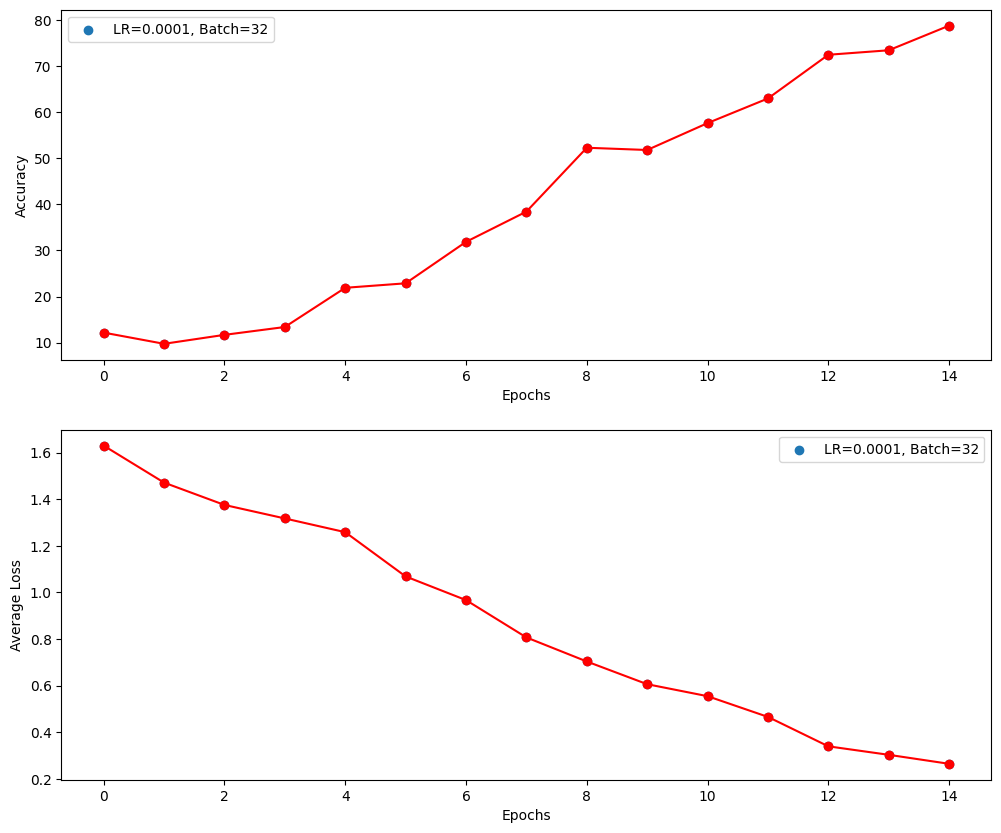

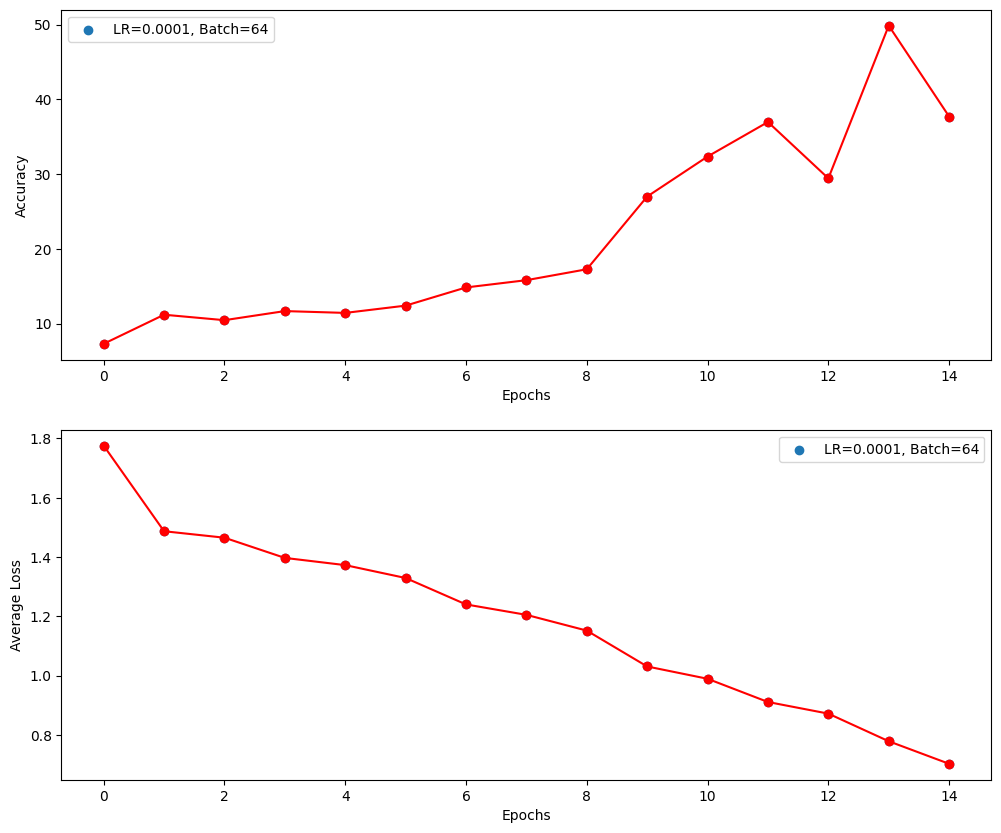

Fold # 5, Epoch [1/5], Step [10/26], Loss: 1.435927391052246
Fold # 5, Epoch [1/5], Step [20/26], Loss: 1.650577425956726
Fold # 5, Epoch [2/5], Step [10/26], Loss: 1.3228414058685303
Fold # 5, Epoch [2/5], Step [20/26], Loss: 1.3005763292312622
Fold # 5, Epoch [3/5], Step [10/26], Loss: 1.4723107814788818
Fold # 5, Epoch [3/5], Step [20/26], Loss: 1.407694935798645
Fold # 5, Epoch [4/5], Step [10/26], Loss: 1.8106203079223633
Fold # 5, Epoch [4/5], Step [20/26], Loss: 1.3620530366897583
Fold # 5, Epoch [5/5], Step [10/26], Loss: 1.2802256345748901
Fold # 5, Epoch [5/5], Step [20/26], Loss: 1.4347418546676636


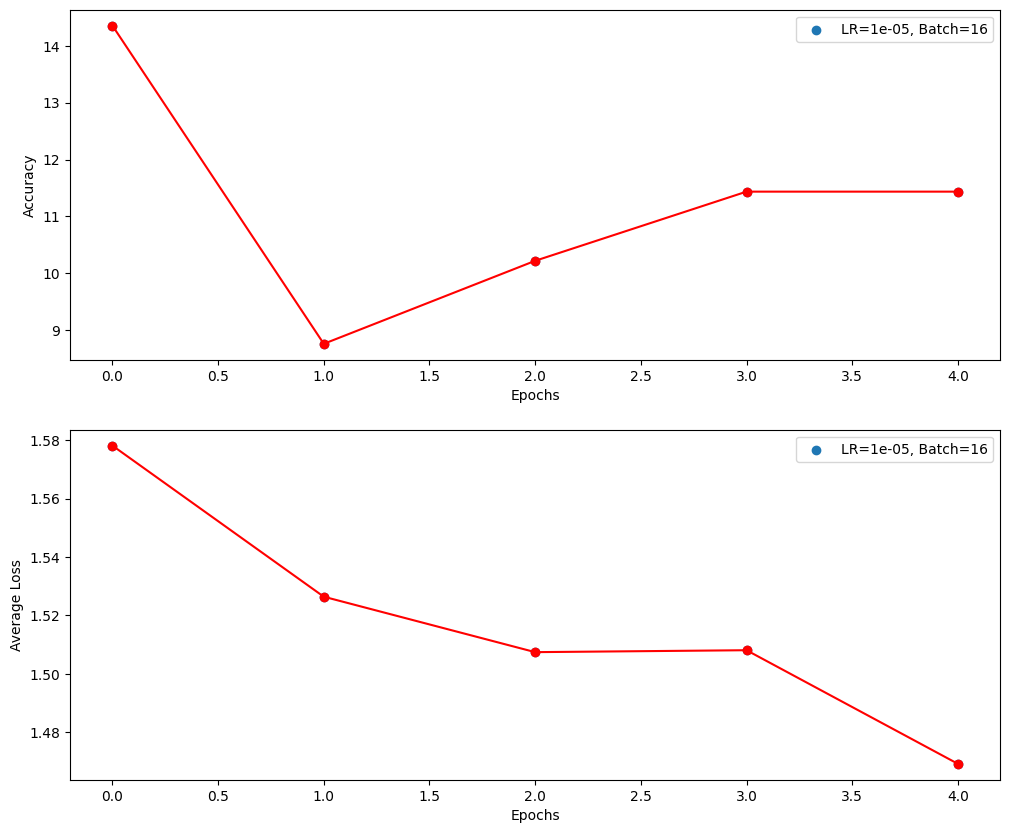

Fold # 5, Epoch [1/5], Step [10/13], Loss: 1.845261573791504
Fold # 5, Epoch [2/5], Step [10/13], Loss: 1.5594342947006226
Fold # 5, Epoch [3/5], Step [10/13], Loss: 1.3926012516021729
Fold # 5, Epoch [4/5], Step [10/13], Loss: 1.5343890190124512
Fold # 5, Epoch [5/5], Step [10/13], Loss: 1.5550984144210815


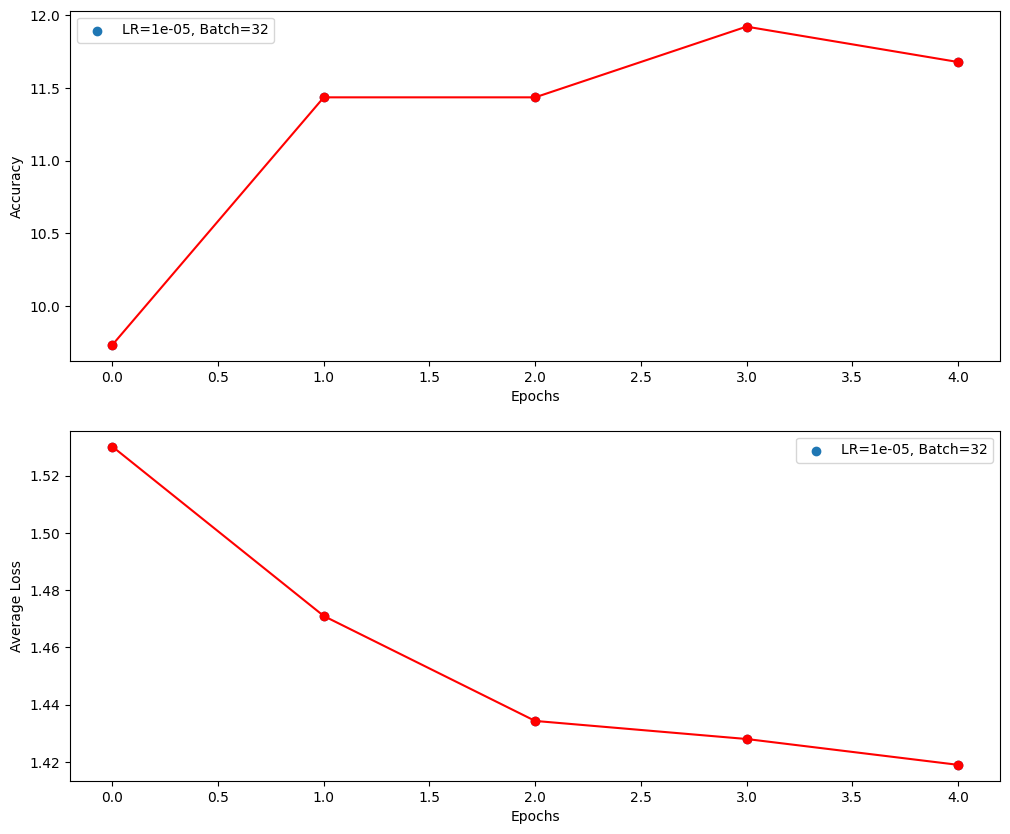

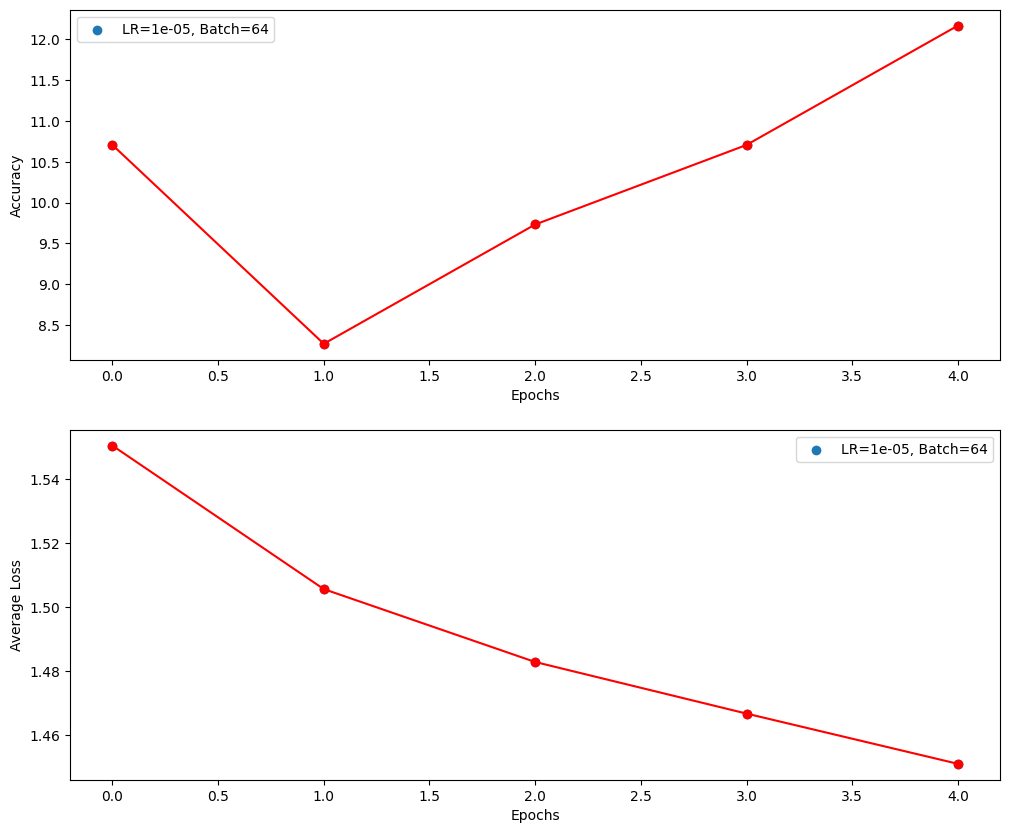

Fold # 5, Epoch [1/5], Step [10/26], Loss: 1.5646603107452393
Fold # 5, Epoch [1/5], Step [20/26], Loss: 1.4977686405181885
Fold # 5, Epoch [2/5], Step [10/26], Loss: 2.0096607208251953
Fold # 5, Epoch [2/5], Step [20/26], Loss: 1.5342944860458374
Fold # 5, Epoch [3/5], Step [10/26], Loss: 1.7253023386001587
Fold # 5, Epoch [3/5], Step [20/26], Loss: 1.3170723915100098
Fold # 5, Epoch [4/5], Step [10/26], Loss: 1.3317279815673828
Fold # 5, Epoch [4/5], Step [20/26], Loss: 1.3031485080718994
Fold # 5, Epoch [5/5], Step [10/26], Loss: 0.9919955134391785
Fold # 5, Epoch [5/5], Step [20/26], Loss: 0.8795520663261414


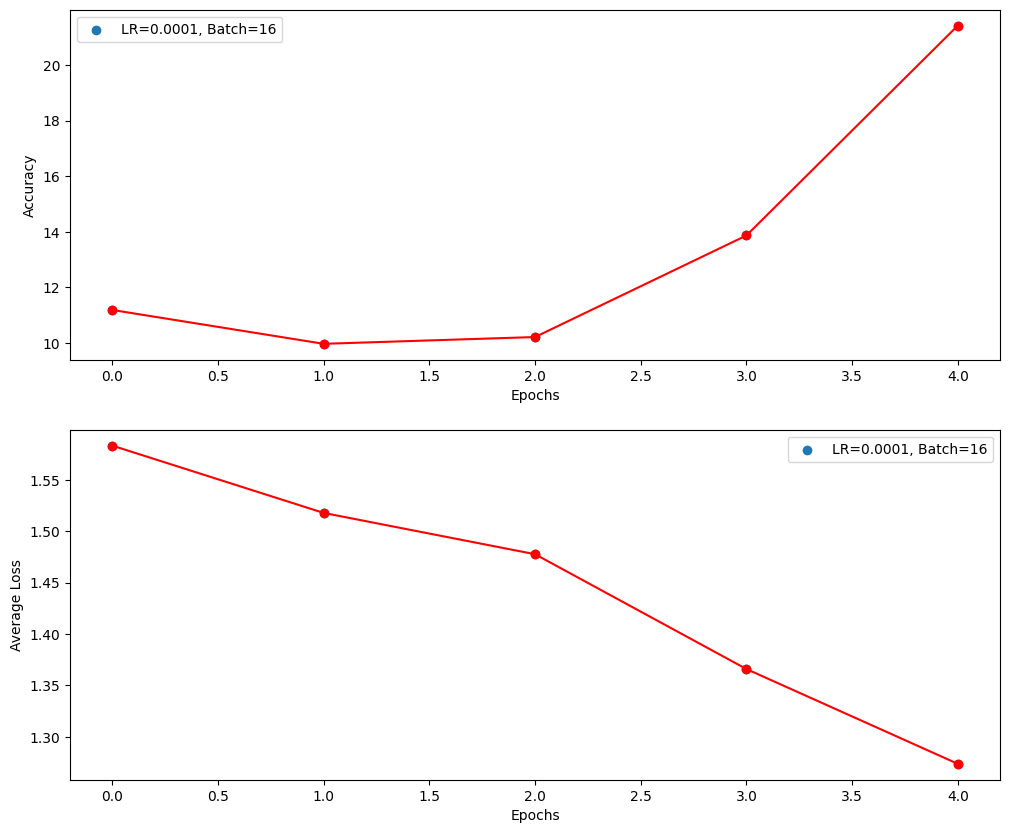

Fold # 5, Epoch [1/5], Step [10/13], Loss: 1.5599758625030518
Fold # 5, Epoch [2/5], Step [10/13], Loss: 1.3127766847610474
Fold # 5, Epoch [3/5], Step [10/13], Loss: 1.3720687627792358
Fold # 5, Epoch [4/5], Step [10/13], Loss: 1.2377872467041016
Fold # 5, Epoch [5/5], Step [10/13], Loss: 1.2758830785751343


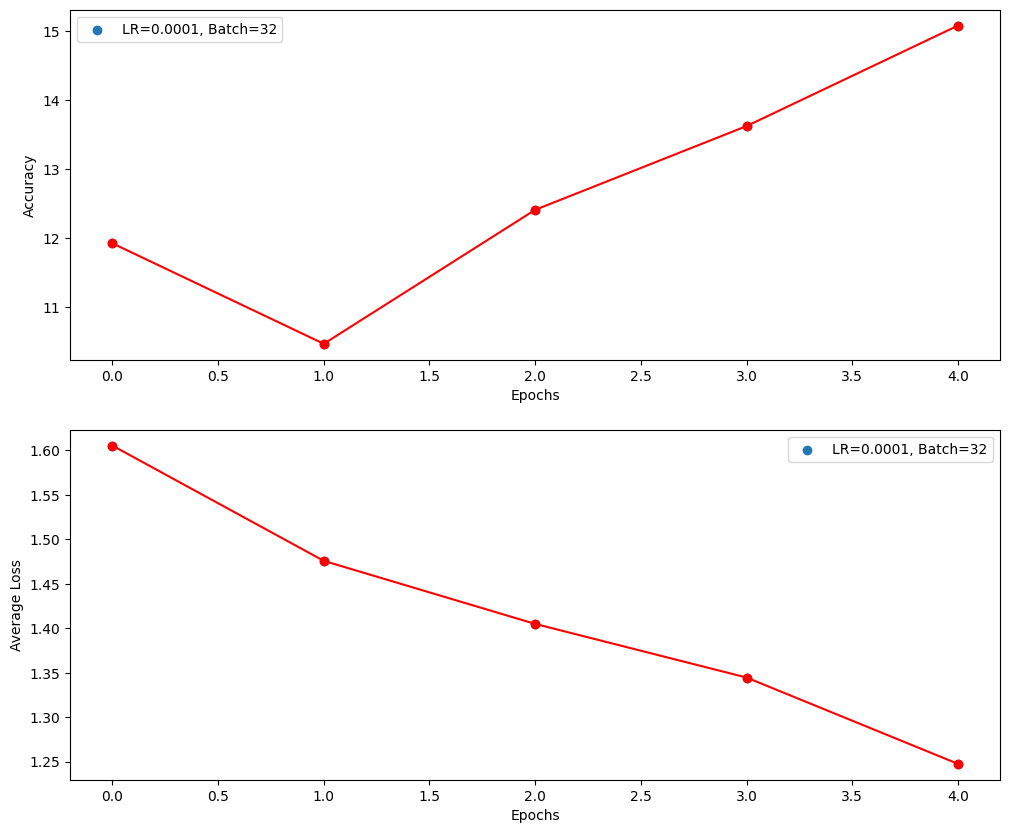

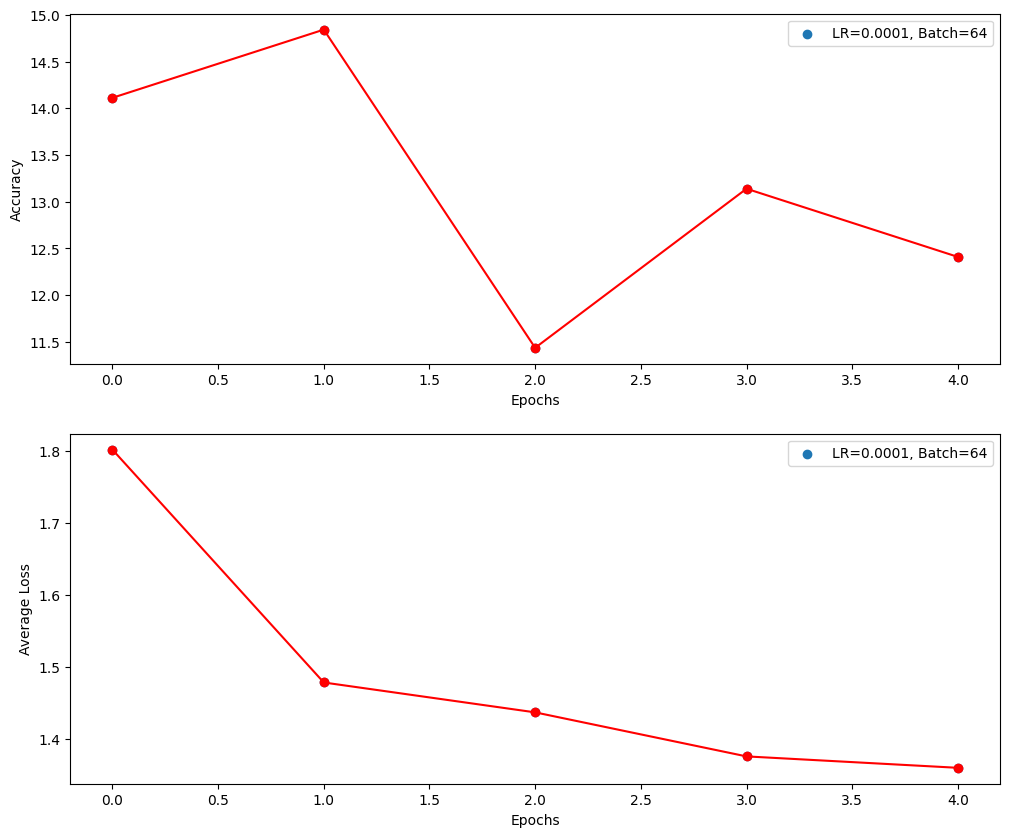

Fold # 5, Epoch [1/10], Step [10/26], Loss: 1.503706455230713
Fold # 5, Epoch [1/10], Step [20/26], Loss: 1.8879755735397339
Fold # 5, Epoch [2/10], Step [10/26], Loss: 1.5045366287231445
Fold # 5, Epoch [2/10], Step [20/26], Loss: 1.411952018737793
Fold # 5, Epoch [3/10], Step [10/26], Loss: 2.011819839477539
Fold # 5, Epoch [3/10], Step [20/26], Loss: 1.3829504251480103
Fold # 5, Epoch [4/10], Step [10/26], Loss: 1.4670268297195435
Fold # 5, Epoch [4/10], Step [20/26], Loss: 1.256687879562378
Fold # 5, Epoch [5/10], Step [10/26], Loss: 1.314054250717163
Fold # 5, Epoch [5/10], Step [20/26], Loss: 1.2098937034606934
Fold # 5, Epoch [6/10], Step [10/26], Loss: 1.8931553363800049
Fold # 5, Epoch [6/10], Step [20/26], Loss: 1.5032356977462769
Fold # 5, Epoch [7/10], Step [10/26], Loss: 1.4577099084854126
Fold # 5, Epoch [7/10], Step [20/26], Loss: 1.588563323020935
Fold # 5, Epoch [8/10], Step [10/26], Loss: 1.2864617109298706
Fold # 5, Epoch [8/10], Step [20/26], Loss: 1.317587018013000

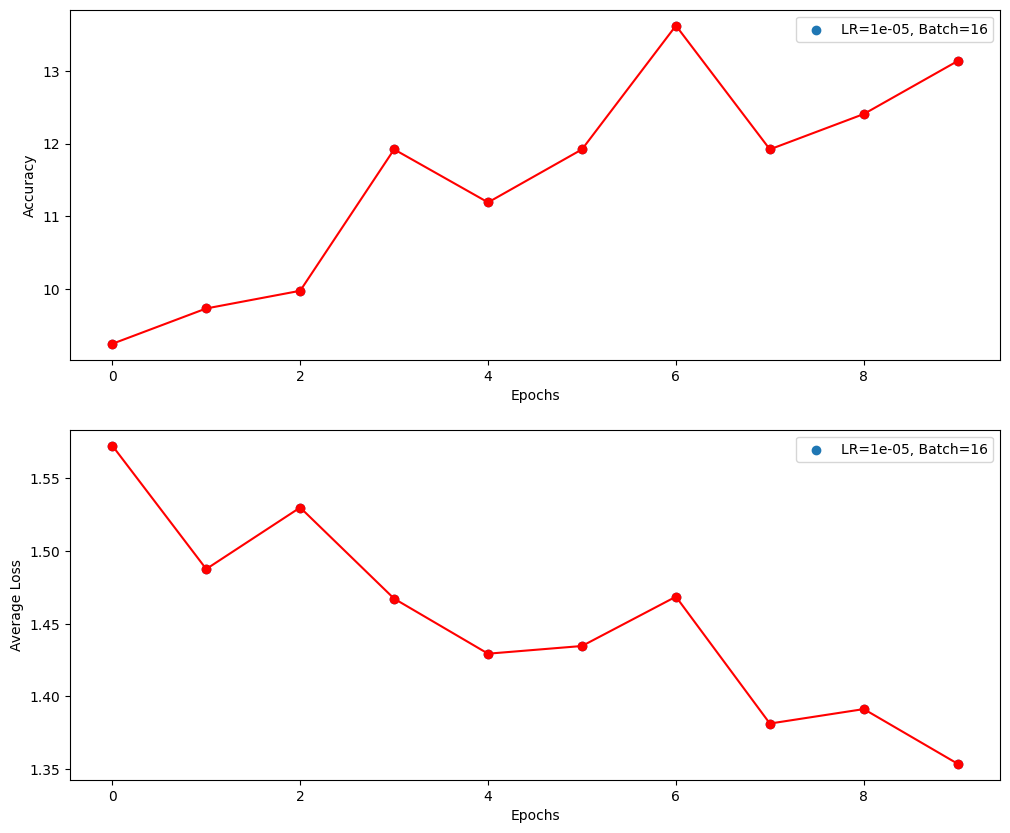

Fold # 5, Epoch [1/10], Step [10/13], Loss: 1.4198122024536133
Fold # 5, Epoch [2/10], Step [10/13], Loss: 1.7203619480133057
Fold # 5, Epoch [3/10], Step [10/13], Loss: 1.420689344406128
Fold # 5, Epoch [4/10], Step [10/13], Loss: 1.3505630493164062
Fold # 5, Epoch [5/10], Step [10/13], Loss: 1.4113184213638306
Fold # 5, Epoch [6/10], Step [10/13], Loss: 1.3500429391860962
Fold # 5, Epoch [7/10], Step [10/13], Loss: 1.6013715267181396
Fold # 5, Epoch [8/10], Step [10/13], Loss: 1.5550987720489502
Fold # 5, Epoch [9/10], Step [10/13], Loss: 1.2172297239303589
Fold # 5, Epoch [10/10], Step [10/13], Loss: 1.3315675258636475


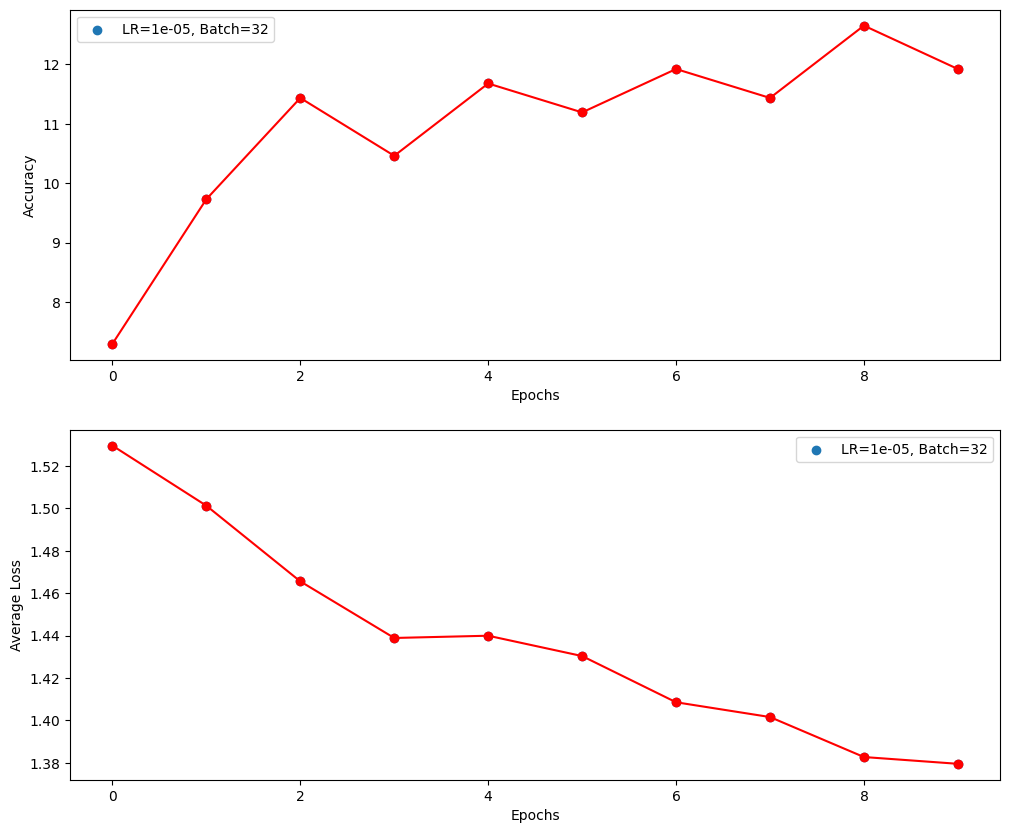

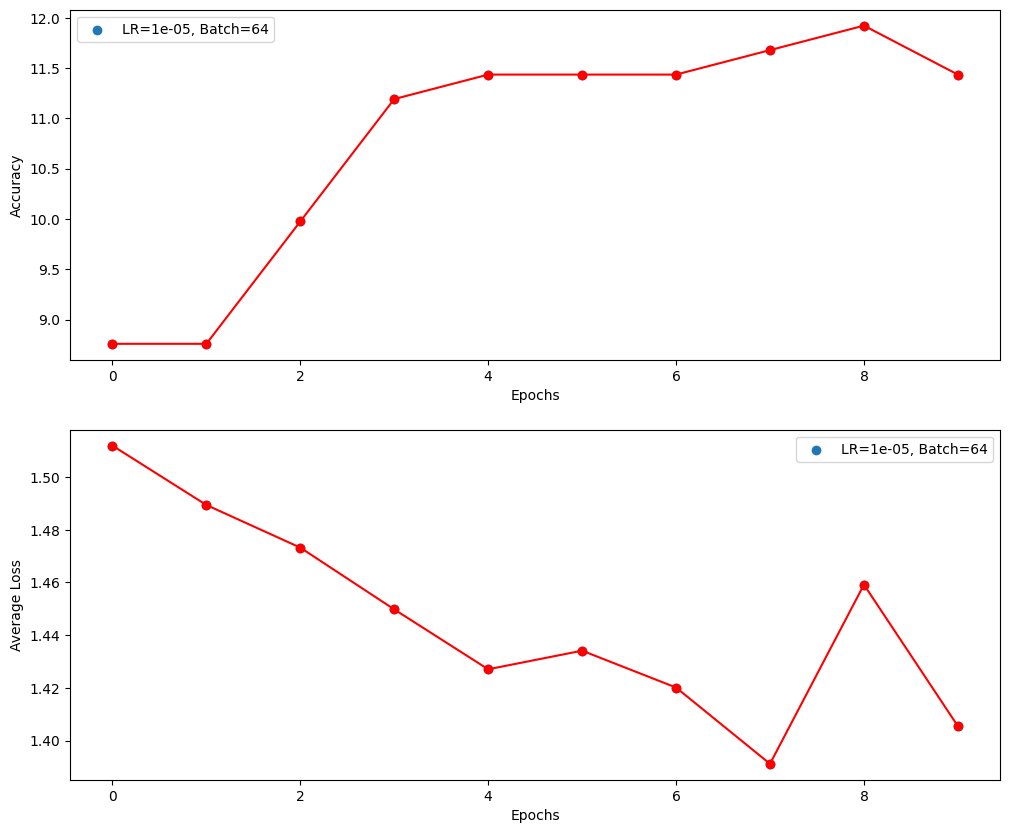

Fold # 5, Epoch [1/10], Step [10/26], Loss: 2.2701656818389893
Fold # 5, Epoch [1/10], Step [20/26], Loss: 2.0315842628479004
Fold # 5, Epoch [2/10], Step [10/26], Loss: 1.4932914972305298
Fold # 5, Epoch [2/10], Step [20/26], Loss: 1.415054440498352
Fold # 5, Epoch [3/10], Step [10/26], Loss: 2.234794855117798
Fold # 5, Epoch [3/10], Step [20/26], Loss: 1.4880988597869873
Fold # 5, Epoch [4/10], Step [10/26], Loss: 1.1534088850021362
Fold # 5, Epoch [4/10], Step [20/26], Loss: 1.5990335941314697


In [25]:
import matplotlib.pyplot as plt

class_weights = torch.tensor([0.5, 10.0, 1.5, 2.0, 10.0])
criterion = nn.CrossEntropyLoss(weight=class_weights)

num_folds_list = [3, 5, 7]
num_epochs_list = [5, 10, 15]
learning_rate_list = [0.00001, 0.0001]
batch_size_list = [16, 32, 64]

results = []

for num_folds in num_folds_list:
    for num_epochs in num_epochs_list:
        for learning_rate in learning_rate_list:
            for batch_size in batch_size_list:

                train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)

                model = CNNModel()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                total_step = len(train_loader)

                accuracies = []
                losses = []

                for epoch in range(num_epochs):
                    current_loss = 0.0
                    correct, all = 0, 0

                    for i, data in enumerate(train_loader):
                        x_imgs, labels = data
                        optimizer.zero_grad()

                        # Forward pass
                        output = model(x_imgs["image"])
                        loss = criterion(output, labels)

                        # Backward and optimize
                        loss.backward()
                        optimizer.step()

                        current_loss += loss.item()

                        _, predicted = torch.max(output.data, 1)
                        all += labels.size(0)
                        correct += (predicted == labels).sum().item()

                        if (i+1) % 10 == 0:
                            print(f'Fold # {num_folds}, Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item()}')

                    average_loss = current_loss / total_step

                    accuracy = 100.0 * correct / all

                    results.append({
                        'num_folds': num_folds,
                        'num_epochs': num_epochs,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'accuracy': accuracy,
                        'average_loss': average_loss,
                    })

                    accuracies.append(accuracy)
                    losses.append(average_loss)

                fig, axs = plt.subplots(2, 1, figsize=(12, 10))
                axs[0].scatter(range(num_epochs), accuracies, label=f"LR={learning_rate}, Batch={batch_size}")
                axs[1].scatter(range(num_epochs), losses, label=f"LR={learning_rate}, Batch={batch_size}")

                axs[0].plot(range(num_epochs), accuracies, linestyle='-', marker='o', color='r')
                axs[1].plot(range(num_epochs), losses, linestyle='-', marker='o', color='r')

                axs[0].legend()
                axs[1].legend()
                axs[0].set_xlabel('Epochs')
                axs[1].set_xlabel('Epochs')
                axs[0].set_ylabel('Accuracy')
                axs[1].set_ylabel('Average Loss')
                plt.show()
